In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 100.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 88.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 149.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 10.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 58.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 102.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 9.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 79.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 32.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 25.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 42.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 30.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 35.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 81.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 140.jpg
/kaggle/input/gizikan/Dataset Gizikan/Tongkol/Tongkol 119.jpg
/kaggle/input/gizika

In [2]:
# Clear all File
!rm -rf /kaggle/working/*

# IMPORT LIBRARY

In [4]:
! pip install Augmentor
! pip install tensorflow
! pip install filetype

In [5]:
#Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Augmentation
import Augmentor
import os
import shutil
from PIL import Image, UnidentifiedImageError
import traceback
import filetype
from pathlib import Path

#Modelling
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

2025-05-16 07:31:10.329084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747380670.580354     371 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747380670.650806     371 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# IMPORT DATA

## Checking Data Validity

In [6]:
img_exts = {"png", "jpg", "jpeg", "gif", "bmp"}
path = Path("/kaggle/input/gizikan/Dataset Gizikan")

for file in path.rglob("*"):
    if file.is_dir():
        continue

    try:
        # Cek tipe file dari isi file-nya (bukan cuma nama)
        with open(file, "rb") as f:
            kind = filetype.guess(f.read(261))

        if kind is None or kind.extension not in img_exts:
            print(f"🛑 FORMAT Unsupported: {file} (detected: {kind})")
            print(f"🗑️ Deleting : {file}")
            file.unlink()
            continue

        # Coba buka dan verifikasi file gambar
        with Image.open(file) as img:
            img.verify()

    except Exception as e:
        print(f"❌ ERROR DURING READ IMAGE: {file} => {e}")
        print(f"🗑️ DELETING..: {file}")
        file.unlink()


In [7]:
#Set Hyperparameter to import data
DATA_DIR = "/kaggle/input/gizikan/Dataset Gizikan"
BATCH_SIZE = 128
IMG_SIZE = 224

In [8]:
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split = 0.2,
    subset = 'training',
    seed= 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE

)
val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split = 0.2,
    subset = 'validation',
    seed= 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 1784 files belonging to 13 classes.
Using 1428 files for training.


I0000 00:00:1747378442.099707      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1784 files belonging to 13 classes.
Using 356 files for validation.


In [9]:
# ==== Path Initiation ====
base_path = "/kaggle/input/gizikan/Dataset Gizikan"
output_aug_dir = "/kaggle/working/Augmentation Dataset"
output_combined_dir = "/kaggle/working/Final Dataset"


# ==== Create Output Folder ====
os.makedirs(output_aug_dir, exist_ok=True)
os.makedirs(output_combined_dir, exist_ok=True)

# ==== Delete Invalid File====
def delete_invalid_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for fname in files:
            if fname.lower().endswith((".avif", ".webp")):
                try:
                    full_path = os.path.join(root, fname)
                    os.remove(full_path)
                    print(f"🗑️ Error File Deleted: {full_path}")
                except Exception as e:
                    print(f"❌ Failed to delete {full_path}: {e}")

delete_invalid_images(base_path)

# ==== Convert All Image to RGB ====
def convert_images_to_rgb(folder_path):
    valid_exts = (".jpg", ".jpeg", ".png")
    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(valid_exts):
            continue  # Skip Non Image File

        file_path = os.path.join(folder_path, fname)
        if os.path.isfile(file_path):
            try:
                with Image.open(file_path) as img:
                    if img.mode != "RGB":
                        img = img.convert("RGB")
                        img.save(file_path)
            except UnidentifiedImageError:
                print(f"❌ Failed to Open File: {file_path}")
            except Exception as e:
                print(f"❌ Error During Conversion {file_path}: {e}")

# ==== LOOP IN EVERY CLASS ====
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    
    if not os.path.isdir(class_path):
        continue  # Skip File, only process folder

    print(f"\n▶️ Process Class: {class_name}")

    # Convert to RGB first
    convert_images_to_rgb(class_path)

    # Create output folder
    aug_class_dir = os.path.join(output_aug_dir, class_name)
    combined_class_dir = os.path.join(output_combined_dir, class_name)
    os.makedirs(aug_class_dir, exist_ok=True)
    os.makedirs(combined_class_dir, exist_ok=True)

    # Augmentation
    try:
        p = Augmentor.Pipeline(source_directory=class_path, output_directory=aug_class_dir)

        # Add transformation
        p.flip_left_right(probability=0.7)
        p.flip_top_bottom(probability=0.3)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.skew(probability=0.4, magnitude=0.5)
        p.crop_random(probability=0.4, percentage_area=0.85)
        p.zoom(probability=0.6, min_factor=1.1, max_factor=1.5)
        p.random_distortion(probability=0.2, grid_width=4, grid_height=4, magnitude=8)
        p.random_contrast(probability=0.2, min_factor=0.7, max_factor=1.3)
        p.random_brightness(probability=0.6, min_factor=0.8, max_factor=1.2)

        # Generate 2000 sample 
        try:
            p.sample(2000)
            print(f"✅ Augmentation Done: {class_name}")
        except Exception as e:
            print(f"❌ Error Augmentation Class {class_name}: {type(e).__name__} - {e}")
            traceback.print_exc()

    except Exception as e:
        print(f"❌ Failed to create a pipeline {class_name}: {type(e).__name__} - {e}")
        traceback.print_exc()
        continue

    # Copy original image
    for image_file in os.listdir(class_path):
        if not image_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        src = os.path.join(class_path, image_file)
        dst = os.path.join(combined_class_dir, image_file)
        try:
            shutil.copy(src, dst)
        except Exception as e:
            print(f"❌ Failed to Copy Original File: {src} -> {e}")

    # Copy augmentation image
    for aug_file in os.listdir(aug_class_dir):
        if not aug_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        src = os.path.join(aug_class_dir, aug_file)
        dst = os.path.join(combined_class_dir, aug_file)
        try:
            shutil.copy(src, dst)
        except Exception as e:
            print(f"❌ Failed to Copy Augmentation FIle: {src} -> {e}")

print("\n🎉 All Done, Final Dataset is Ready!")

try:
    shutil.rmtree(output_aug_dir)
    print(f"🗑️ Folder '{output_aug_dir}' Deleted.")
except Exception as e:
    print(f"❌ Failed to delete folder '{output_aug_dir}': {e}")



▶️ Process Class: Tongkol
Initialised with 153 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Tongkol.

Processing <PIL.Image.Image image mode=RGB size=1200x675 at 0x7E2225F36410>: 100%|██████████| 2000/2000 [02:04<00:00, 16.11 Samples/s] 


✅ Augmentation Done: Tongkol

▶️ Process Class: Patin
Initialised with 143 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Patin.

Processing <PIL.Image.Image image mode=RGB size=500x181 at 0x7E2225F1EB10>: 100%|██████████| 2000/2000 [01:07<00:00, 29.85 Samples/s]  


✅ Augmentation Done: Patin

▶️ Process Class: Kakap Putih
Initialised with 134 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Kakap Putih.

Processing <PIL.Image.Image image mode=RGB size=870x655 at 0x7E22500BDC50>: 100%|██████████| 2000/2000 [03:00<00:00, 11.05 Samples/s]                  


✅ Augmentation Done: Kakap Putih

▶️ Process Class: Nila
Initialised with 144 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Nila.

Processing <PIL.Image.Image image mode=RGB size=384x510 at 0x7E2225F1D610>: 100%|██████████| 2000/2000 [02:36<00:00, 12.81 Samples/s]                  


✅ Augmentation Done: Nila

▶️ Process Class: Mujair
Initialised with 140 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Mujair.

Processing <PIL.Image.Image image mode=RGB size=652x870 at 0x7E224852A790>: 100%|██████████| 2000/2000 [02:03<00:00, 16.24 Samples/s]                    


✅ Augmentation Done: Mujair

▶️ Process Class: Tuna
Initialised with 168 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Tuna.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E22B6B02E10>: 100%|██████████| 2000/2000 [01:41<00:00, 19.67 Samples/s]                  


✅ Augmentation Done: Tuna

▶️ Process Class: Lele
Initialised with 130 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Lele.

Processing <PIL.Image.Image image mode=RGB size=2560x1440 at 0x7E225D627490>: 100%|██████████| 2000/2000 [02:15<00:00, 14.78 Samples/s]                


✅ Augmentation Done: Lele

▶️ Process Class: Cakalang
Initialised with 134 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Cakalang.

Processing <PIL.Image.Image image mode=RGB size=324x155 at 0x7E224854BD50>: 100%|██████████| 2000/2000 [02:12<00:00, 15.08 Samples/s]                 


✅ Augmentation Done: Cakalang

▶️ Process Class: Kakap Merah
Initialised with 135 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Kakap Merah.

Processing <PIL.Image.Image image mode=RGB size=1000x750 at 0x7E2225F2C710>: 100%|██████████| 2000/2000 [02:53<00:00, 11.50 Samples/s]                  


✅ Augmentation Done: Kakap Merah

▶️ Process Class: Bandeng
Initialised with 158 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Bandeng.

Processing <PIL.Image.Image image mode=RGB size=800x502 at 0x7E225099D4D0>: 100%|██████████| 2000/2000 [01:49<00:00, 18.26 Samples/s]                  


✅ Augmentation Done: Bandeng

▶️ Process Class: Tengiri
Initialised with 130 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Tengiri.

Processing <PIL.Image.Image image mode=RGB size=576x1024 at 0x7E2225F6AB90>: 100%|██████████| 2000/2000 [02:09<00:00, 15.49 Samples/s]                 


✅ Augmentation Done: Tengiri

▶️ Process Class: Kembung
Initialised with 122 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Kembung.

Processing <PIL.Image.Image image mode=RGB size=1305x1740 at 0x7E22B6B57BD0>: 100%|██████████| 2000/2000 [02:20<00:00, 14.20 Samples/s]              


✅ Augmentation Done: Kembung

▶️ Process Class: Teri
Initialised with 93 image(s) found.
Output directory set to /kaggle/working/Augmentation Dataset/Teri.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7E22C5DE72D0>: 100%|██████████| 2000/2000 [02:38<00:00, 12.60 Samples/s]


✅ Augmentation Done: Teri

🎉 All Done, Final Dataset is Ready!
🗑️ Folder '/kaggle/working/Augmentation Dataset' Deleted.


## Rename Data

In [10]:
# Base Data Path
base_path = "/kaggle/working/Final Dataset"

for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)

    if os.path.isdir(class_path):
        print(f"\n=== Processed Class: {class_name} ===")

        file_list = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        file_list.sort()

        # Step 1 : Change file name to 'sample temp'
        for i, filename in enumerate(file_list, start=1):
            old_path = os.path.join(class_path, filename)
            temp_name = f"sample_temp_{i}.jpg"
            temp_path = os.path.join(class_path, temp_name)
            os.rename(old_path, temp_path)

        # Tahap 2: Rename file name to 'class name'
        temp_list = [f for f in os.listdir(class_path) if f.startswith("sample_temp_")]
        temp_list.sort()

        for i, temp_filename in enumerate(temp_list, start=1):
            temp_path = os.path.join(class_path, temp_filename)
            final_name = f"{class_name} {i}.jpg"
            final_path = os.path.join(class_path, final_name)
            os.rename(temp_path, final_path)
            print(f"Renamed: {temp_filename} → {final_name}")

print("All Done!!")



=== Processed Class: Lele ===
Renamed: sample_temp_1.jpg → Lele 1.jpg
Renamed: sample_temp_10.jpg → Lele 2.jpg
Renamed: sample_temp_100.jpg → Lele 3.jpg
Renamed: sample_temp_1000.jpg → Lele 4.jpg
Renamed: sample_temp_1001.jpg → Lele 5.jpg
Renamed: sample_temp_1002.jpg → Lele 6.jpg
Renamed: sample_temp_1003.jpg → Lele 7.jpg
Renamed: sample_temp_1004.jpg → Lele 8.jpg
Renamed: sample_temp_1005.jpg → Lele 9.jpg
Renamed: sample_temp_1006.jpg → Lele 10.jpg
Renamed: sample_temp_1007.jpg → Lele 11.jpg
Renamed: sample_temp_1008.jpg → Lele 12.jpg
Renamed: sample_temp_1009.jpg → Lele 13.jpg
Renamed: sample_temp_101.jpg → Lele 14.jpg
Renamed: sample_temp_1010.jpg → Lele 15.jpg
Renamed: sample_temp_1011.jpg → Lele 16.jpg
Renamed: sample_temp_1012.jpg → Lele 17.jpg
Renamed: sample_temp_1013.jpg → Lele 18.jpg
Renamed: sample_temp_1014.jpg → Lele 19.jpg
Renamed: sample_temp_1015.jpg → Lele 20.jpg
Renamed: sample_temp_1016.jpg → Lele 21.jpg
Renamed: sample_temp_1017.jpg → Lele 22.jpg
Renamed: sample_t

## Re Import Data

In [6]:
#Set Hyperparameter to import data
NEW_DATA_DIR = "/kaggle/working/Final Dataset"
BATCH_SIZE = 32
IMG_SIZE = 224

In [7]:
train_ds = image_dataset_from_directory(
    NEW_DATA_DIR,
    validation_split = 0.2,
    subset = 'training',
    seed= 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE

)
val_ds = image_dataset_from_directory(
    NEW_DATA_DIR,
    validation_split = 0.2,
    subset = 'validation',
    seed= 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 27784 files belonging to 13 classes.
Using 22228 files for training.


I0000 00:00:1747380699.891828     371 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 27784 files belonging to 13 classes.
Using 5556 files for validation.


## Check Class Name

In [8]:
classnames = train_ds.class_names
print('Class Names in Dataset : ')
for i, fish in enumerate(classnames):
    print (f'{i}. {fish}')

Class Names in Dataset : 
0. Bandeng
1. Cakalang
2. Kakap Merah
3. Kakap Putih
4. Kembung
5. Lele
6. Mujair
7. Nila
8. Patin
9. Tengiri
10. Teri
11. Tongkol
12. Tuna


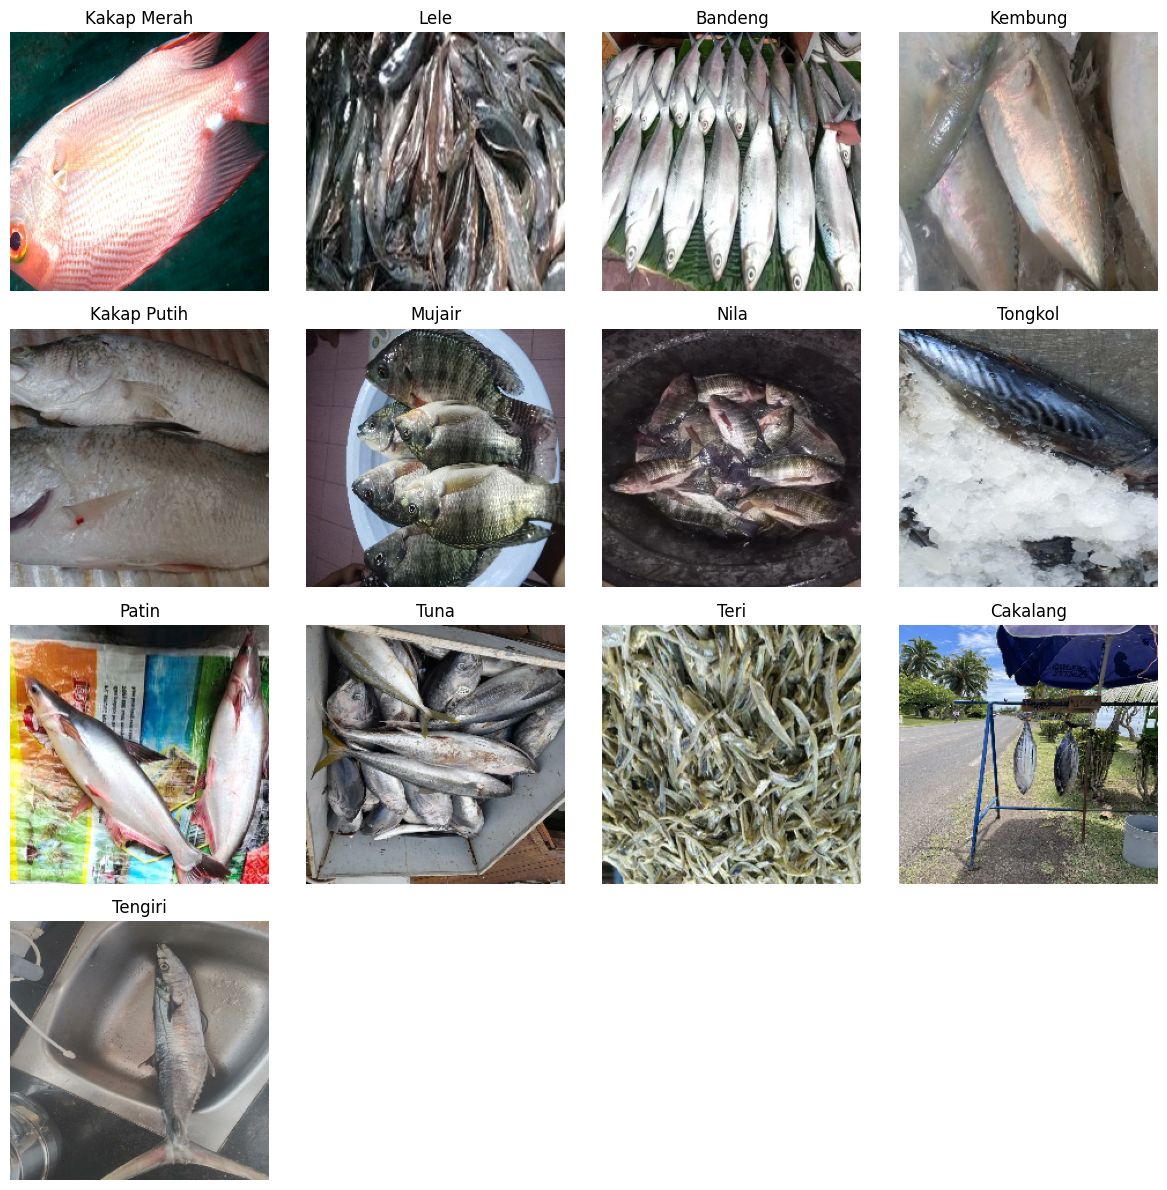

In [9]:
plt.figure(figsize=(12, 12))

shown_classes = set()
max_per_class = 1  # This variable is no longer strictly necessary for checking, but kept for context.
i = 1

for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = classnames[label.numpy()]

        # Check if the class_name has already been shown
        if class_name not in shown_classes:
            ax = plt.subplot(4, 4, i)
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            i += 1

            # Add the class_name to the set to mark it as shown
            shown_classes.add(class_name)

        # Stop if we have shown one image from each class
        if len(shown_classes) == len(classnames):
            break
    # Stop if we have shown one image from each class across all batches
    if len(shown_classes) == len(classnames):
        break

plt.tight_layout()
plt.show()

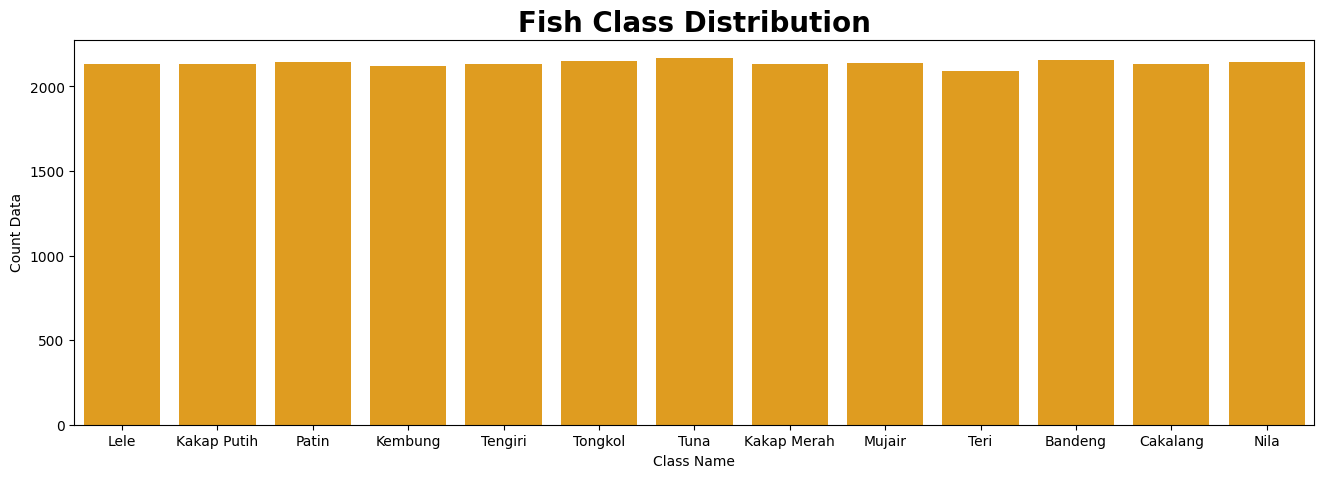

In [10]:
# take classname from new data directory
class_names = os.listdir(NEW_DATA_DIR)

# Count the data
data_count = {}
for class_name in class_names:
    class_folder = os.path.join(NEW_DATA_DIR, class_name)
    if os.path.isdir(class_folder):  # Make sure it is a folder
        file_count = len([f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png', '.jpeg'))])
        data_count[class_name] = file_count

# Convert to dataframe
df = pd.DataFrame(list(data_count.items()), columns=['Class', 'Count'])

# Plot
plt.figure(figsize= (16, 5))
sns.barplot(
    data=df,
    x='Class',
    y= 'Count',
    color= 'orange'
)
plt.xlabel('Class Name')
plt.ylabel('Count Data')
plt.title('Fish Class Distribution', fontsize = 20, fontweight= 'bold')
plt.show()

# Data Preprocessing

## Data Preparation

In [11]:
# Data preparation
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

# Apply preprocess to dataset
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Modelling

## Set Hyper Parameter, Early Stopping & Learning Rate Scheduller


In [12]:
#Hyperparameter for Training
epoch = 20
batch = 32

#Early Stopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

#Learning Rate Scheduller
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

## Build Model Using Mobilenetv2

Using Mobilenet V2 for Base Model

In [13]:
base_model = MobileNetV2(
    weights = 'imagenet',
    include_top = False,
    name = 'MobilenetV2',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

In [14]:
# Modelling using mobilenetv2 as a core model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(len(classnames), activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=x, name='Gizikan_Model')

# Check model summary
model.summary()

Model: "Gizikan_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,101,197 (15.64 MB)

 Trainable params: 1,843,213 (7.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compile Model

Using Adam as a Optimizer, sparse categorical crossentropy for loss, and Accuracy as Metrics

In [15]:
model.compile(
    optimizer = Adam(learning_rate= lr_schedule),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

## Training Model

set epoch at 20 itteration, 128 batch, and using shuffle to shuffle the data in the training process

In [16]:
history1 = model.fit(
    train_ds,
    batch_size = batch,
    epochs = epoch,
    validation_data = val_ds,
    )

Epoch 1/20


I0000 00:00:1747380868.291234     424 service.cc:148] XLA service 0x7d9374003810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747380868.292228     424 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747380869.195761     424 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/695 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.1179 - loss: 2.7135

I0000 00:00:1747380873.937443     424 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


695/695 ━━━━━━━━━━━━━━━━━━━━ 103s 46ms/step - accuracy: 0.5673 - loss: 1.3356 - val_accuracy: 0.8594 - val_loss: 0.4293
Epoch 2/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8583 - loss: 0.4250 - val_accuracy: 0.9170 - val_loss: 0.2690
Epoch 3/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9060 - loss: 0.2726 - val_accuracy: 0.9386 - val_loss: 0.1991
Epoch 4/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9391 - loss: 0.1837 - val_accuracy: 0.9509 - val_loss: 0.1585
Epoch 5/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9641 - loss: 0.1208 - val_accuracy: 0.9512 - val_loss: 0.1497
Epoch 6/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9749 - loss: 0.0843 - val_accuracy: 0.9563 - val_loss: 0.1332
Epoch 7/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9813 - loss: 0.0647 - val_accuracy: 0.9600 - val_loss: 0.1156
Epoch 8/20
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9859 - loss: 0.0475 - val_accura

# Model Evaluation

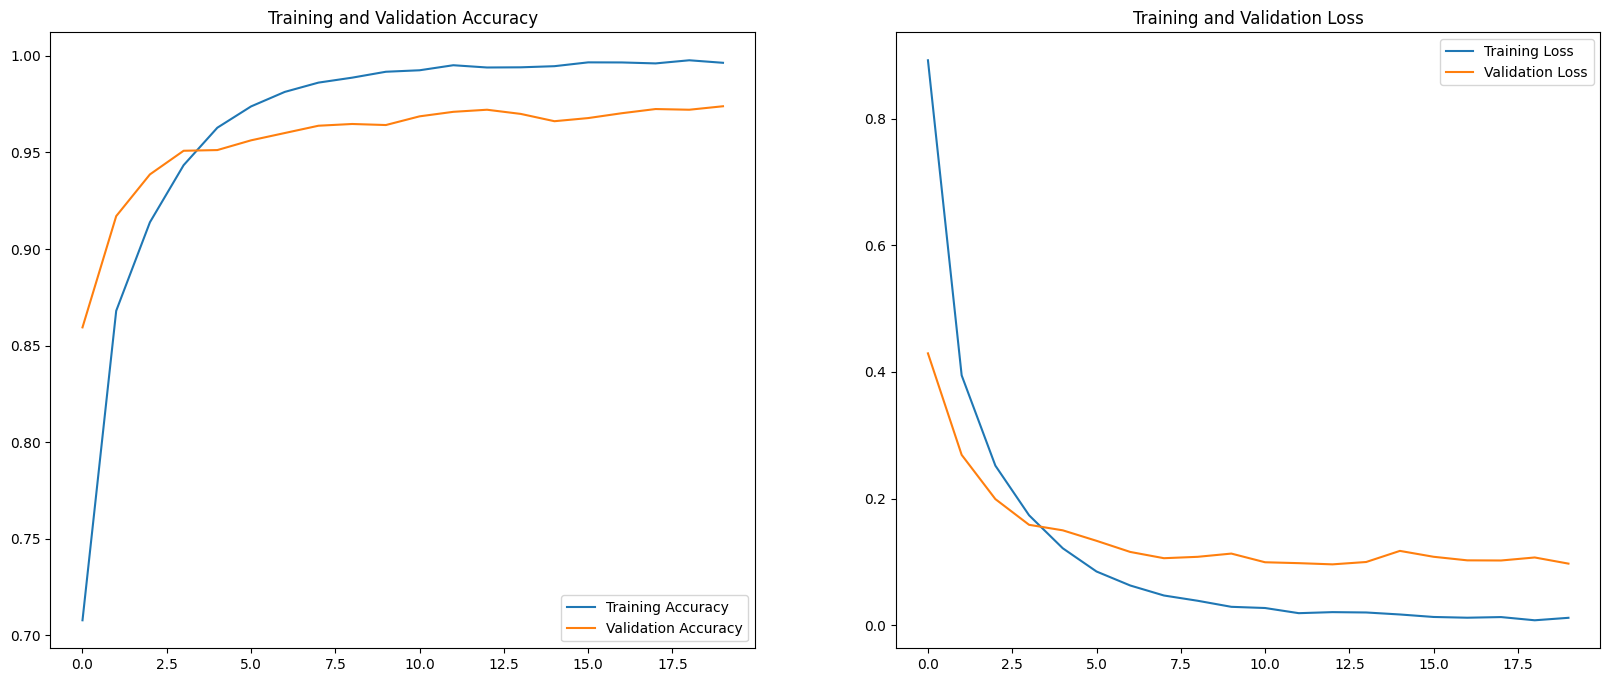

In [17]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
loss, acc = model.evaluate(val_ds)
print (f'Model loss : {loss}, Model Accuracy : {acc}')


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9771 - loss: 0.0970
Model loss : 0.09712768346071243, Model Accuracy : 0.9739021062850952


## Confusion Matrix

174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step


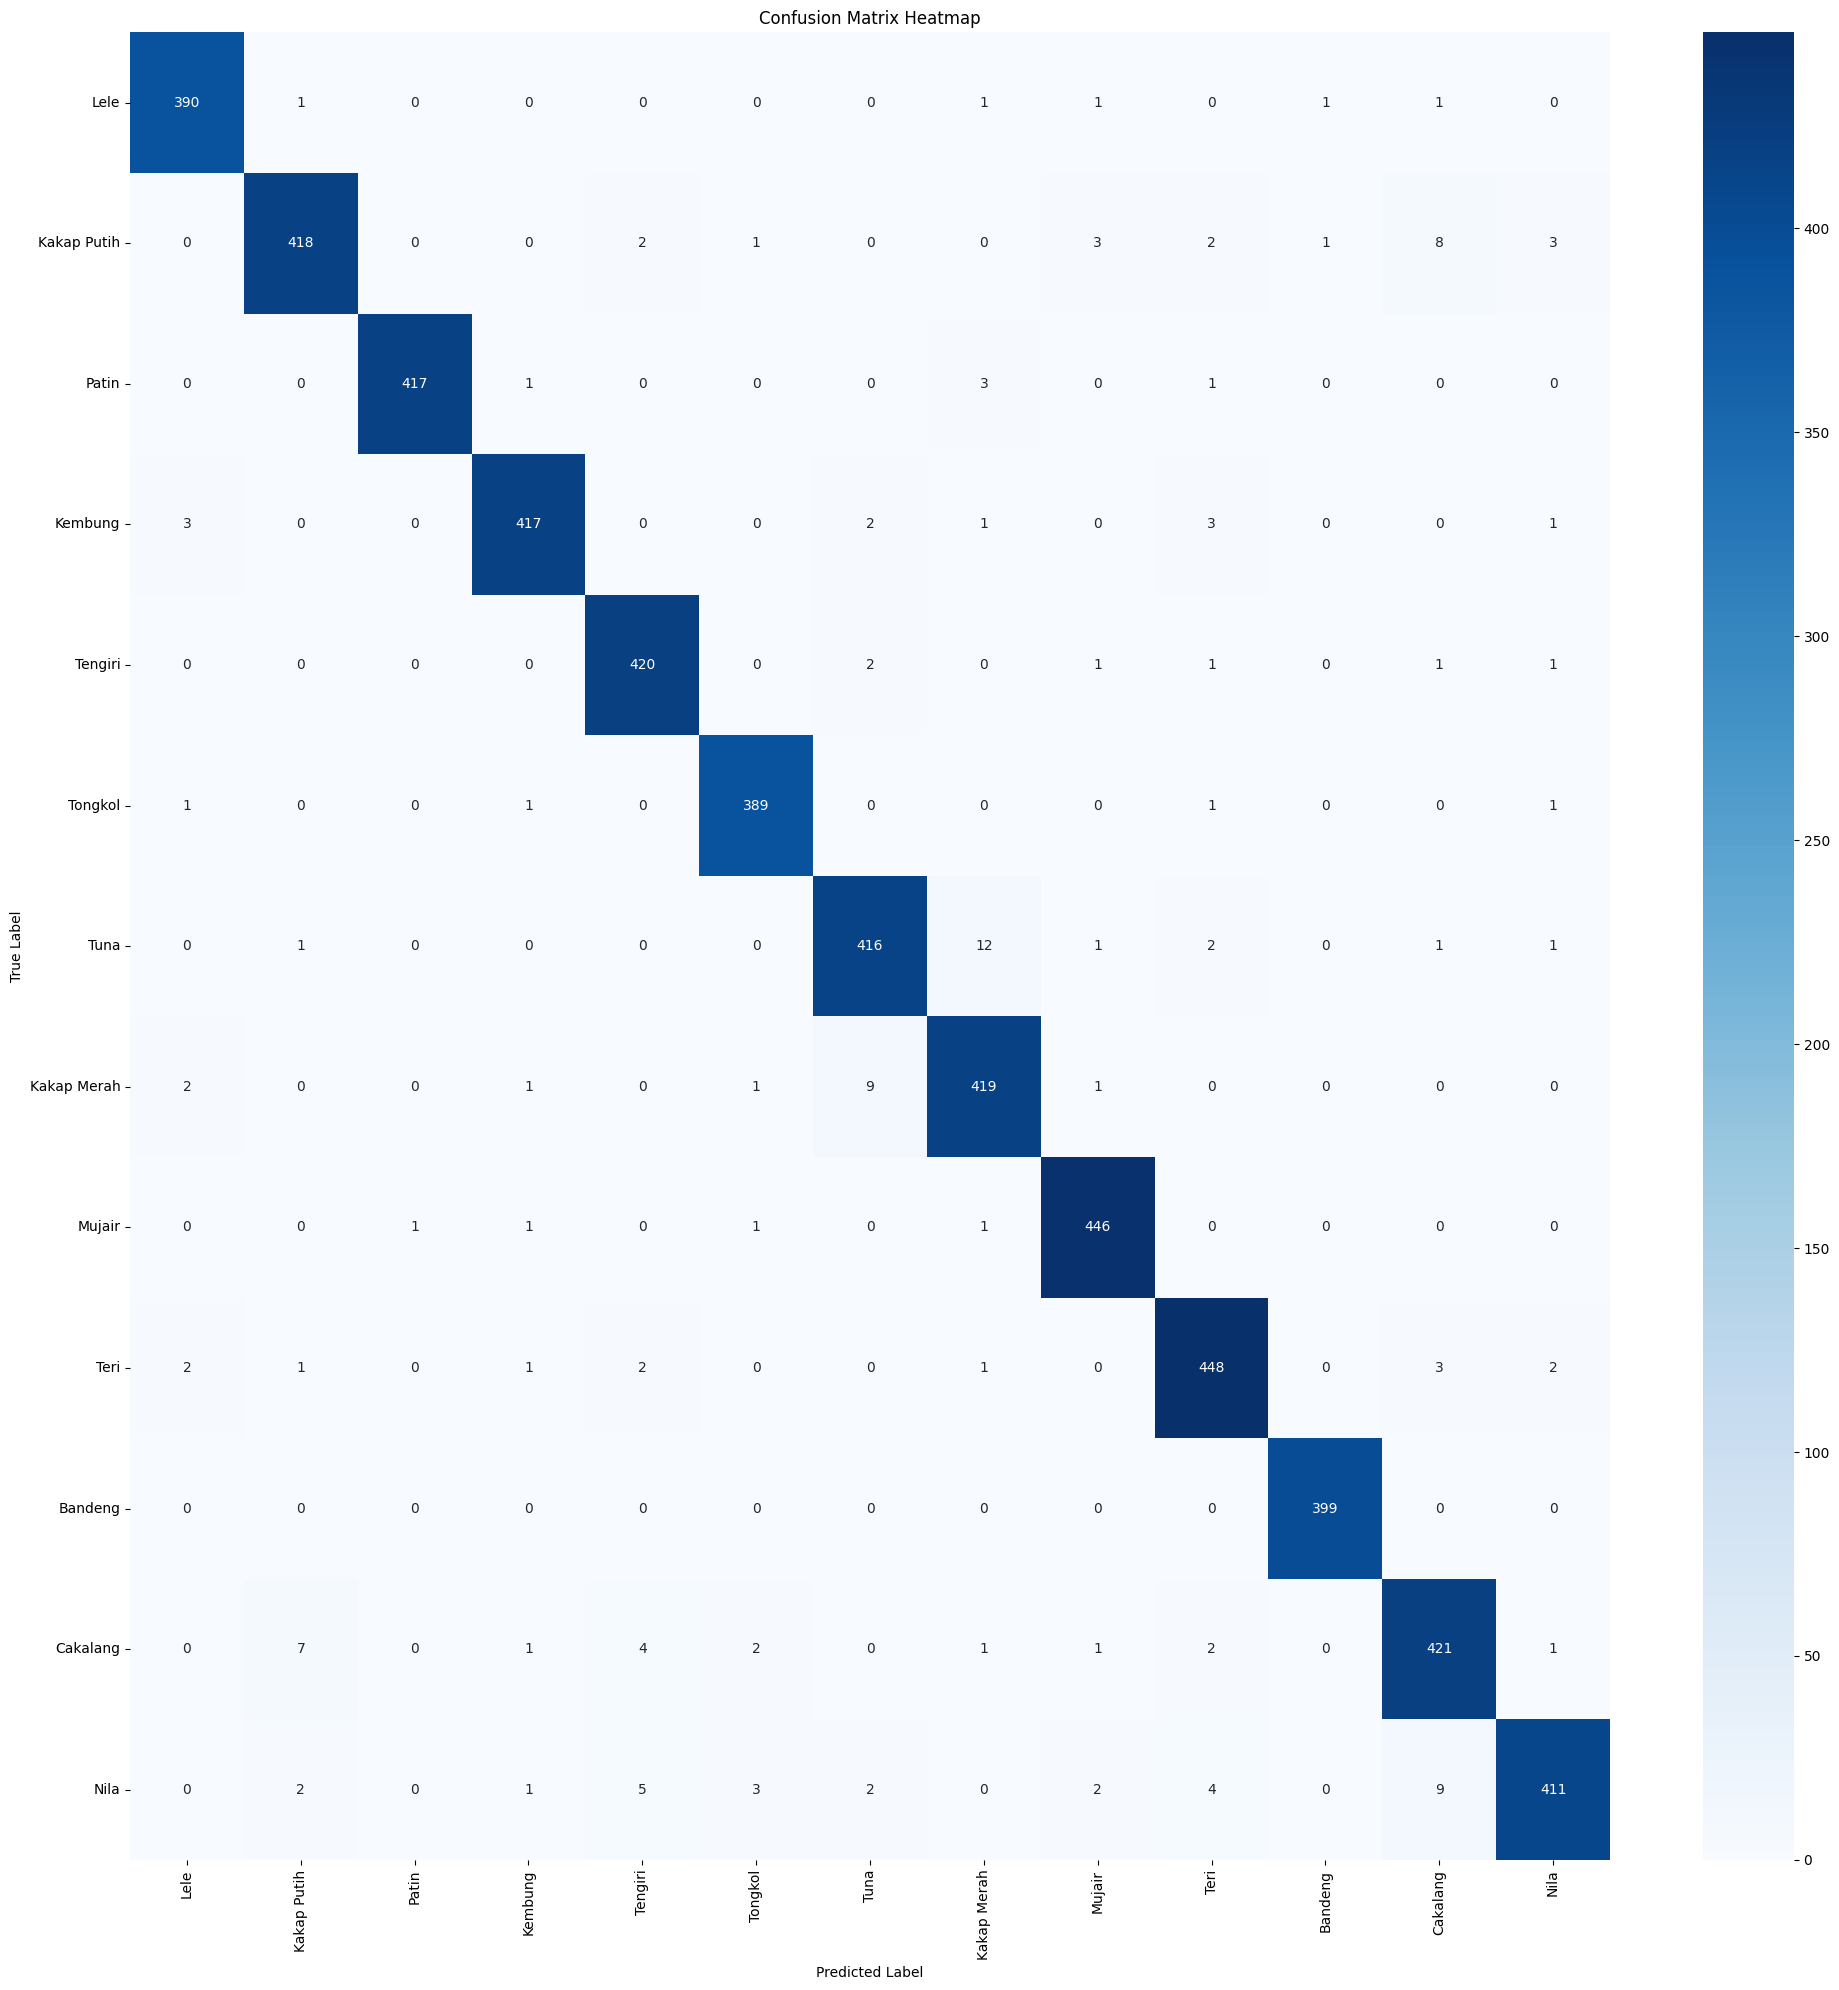

In [19]:
# take true labels from val_ds
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# model predict
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Heatmap visualization
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

## Evaluation Matrix

In [20]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

        Lele       0.98      0.99      0.98       395
 Kakap Putih       0.97      0.95      0.96       438
       Patin       1.00      0.99      0.99       422
     Kembung       0.98      0.98      0.98       427
     Tengiri       0.97      0.99      0.98       426
     Tongkol       0.98      0.99      0.98       393
        Tuna       0.97      0.96      0.96       434
 Kakap Merah       0.95      0.97      0.96       433
      Mujair       0.98      0.99      0.98       450
        Teri       0.97      0.97      0.97       460
     Bandeng       1.00      1.00      1.00       399
    Cakalang       0.95      0.96      0.95       440
        Nila       0.98      0.94      0.96       439

    accuracy                           0.97      5556
   macro avg       0.97      0.97      0.97      5556
weighted avg       0.97      0.97      0.97      5556



The model performance is already very good without fine tuning, so there is no need to do fine tuning and use this model as a Gizikan Application prediction model.

# Save Model

In [22]:
model.save('/kaggle/working/Model/Gizikan_Model.h5')

save the model in h5 format so it can be used in streamlit

In [24]:
from tensorflow.keras.models import load_model

load_model = load_model('/kaggle/working/Model/Gizikan_Model.h5')
load_model.summary()

Model: "Gizikan_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,101,198 (15.64 MB)

 Trainable params: 1,843,213 (7.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 1 (8.00 B)

# Test Model to Predict New Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


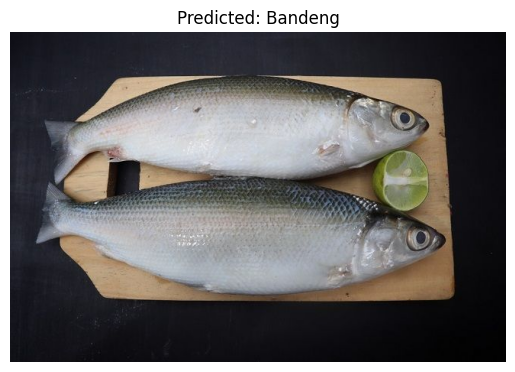

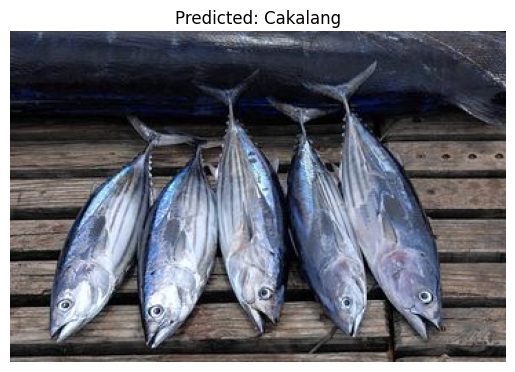

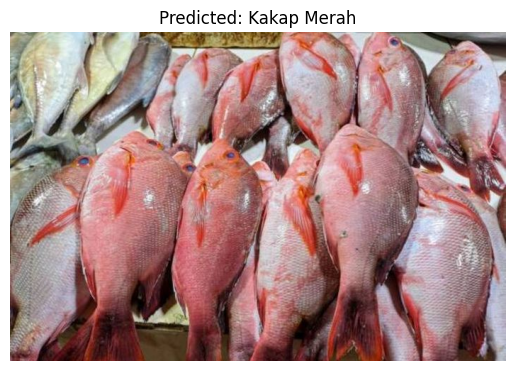

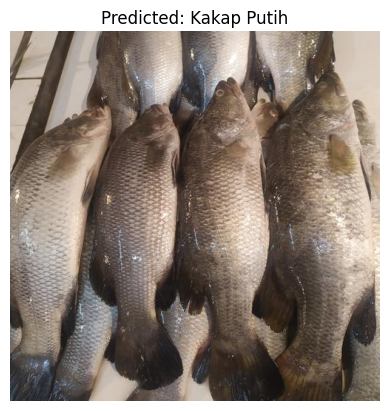

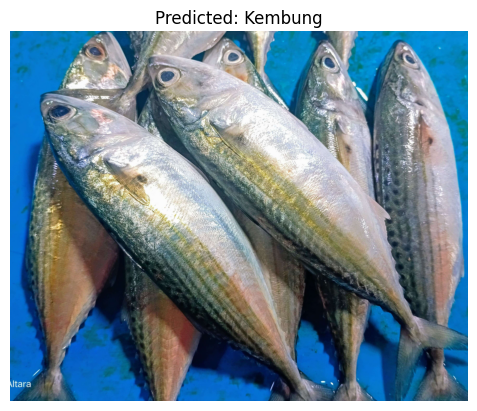

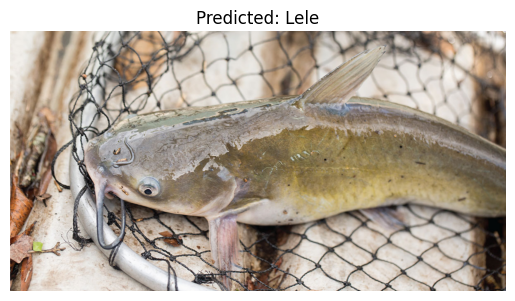

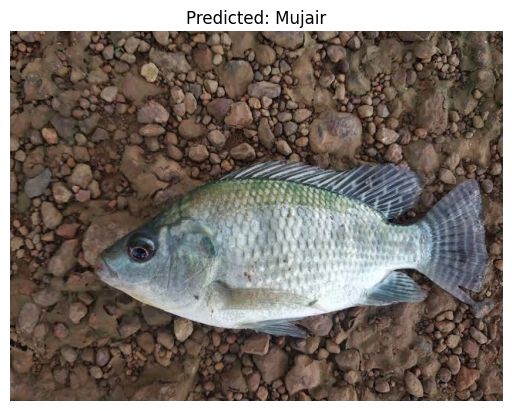

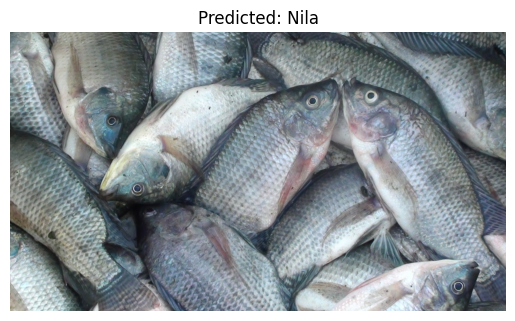

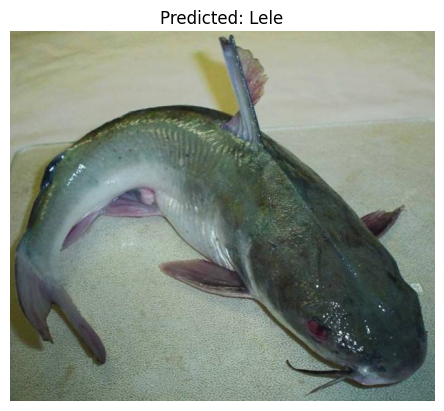

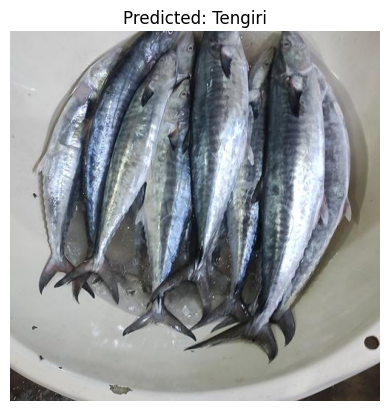

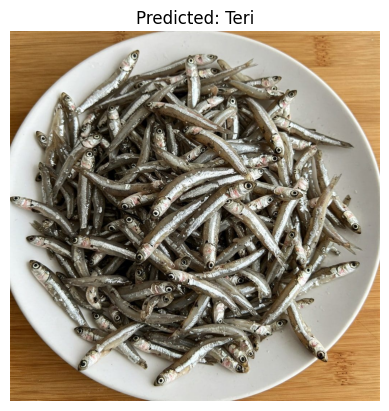

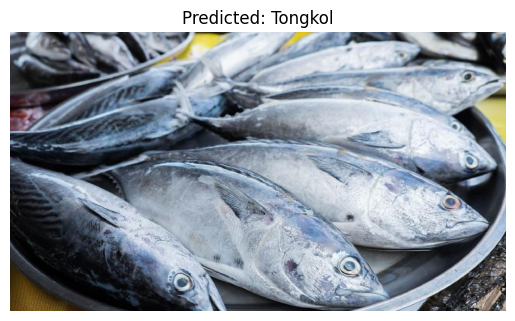

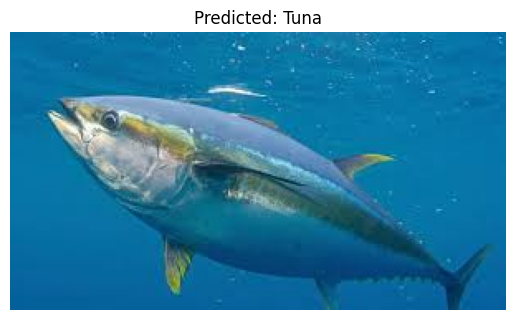

In [28]:
from tensorflow.keras.preprocessing import image
# List gambar yang mau diprediksi
image_paths = [
    "/kaggle/input/test-gizikan/bandeng.jpg",
    "/kaggle/input/test-gizikan/cakalang.jpg",
    "/kaggle/input/test-gizikan/kakap merah.jpg",
    "/kaggle/input/test-gizikan/kakap.jpg",
    "/kaggle/input/test-gizikan/kembung.jpeg",
    "/kaggle/input/test-gizikan/lele.jpg",
    "/kaggle/input/test-gizikan/mujair.jpg",
    "/kaggle/input/test-gizikan/nila.jpg",
    "/kaggle/input/test-gizikan/patin.jpg",
    "/kaggle/input/test-gizikan/tenggiri.jpg",
    "/kaggle/input/test-gizikan/teri.jpeg",
    "/kaggle/input/test-gizikan/tongkol.jpeg",
    "/kaggle/input/test-gizikan/tuna.jpg",
]

# Load & preprocess multiple images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Preprocess all images
images = [load_and_preprocess_image(p) for p in image_paths]
image_batch = np.array(images)  # batch shape: (N, IMG_SIZE, IMG_SIZE, 3)

# Predict all at once
predictions = load_model.predict(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

# Tampilkan hasil
for i, img_path in enumerate(image_paths):
    predicted_label = classnames[predicted_classes[i]]
    plt.figure()
    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


After checking, the model is good at predicting new data.

In [29]:
import json

# Save Classname to model_labels.json
with open("labels.json", "w") as f:
    json.dump(classnames, f)


['Bandeng',
 'Cakalang',
 'Kakap Merah',
 'Kakap Putih',
 'Kembung',
 'Lele',
 'Mujair',
 'Nila',
 'Patin',
 'Tengiri',
 'Teri',
 'Tongkol',
 'Tuna']